# Eigen Class Activation Mapping (CAM)

This notebook has been adapted from [Jacob Gil's excellent tutorial](https://jacobgil.github.io/pytorch-gradcam-book/EigenCAM%20for%20YOLO5.html). It allows the visualisation of the model attention in each image, to better understand why it makes specific decisions around detection and class.

We will use the PAGS8-trained YOLOv5-S and YOLOv5-X models on 1280 x 1280 images from fold 0.

A key consideration when using Eigen-CAM is the target layer within the model. We're going to use the second last layer within the dection layer. But you can play around with this value and the model to see how it changes.

This is done in:

    ```python
    model.model.model.model[-2]
    ```

<img src="https://github.com/geezacoleman/Palmer-detection/assets/51358498/a929c774-f570-4eb2-95c4-c70cb507de8b"/>


In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

This package needs to load custom models, and as such requires a local YOLOv5 repository. Either clone the repository from the official Ultralytics repository or if you're using the Palmer-detection repository, supply the path to the yolov5 folder.

Install the requirements.txt file in that directory.

In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/Palmer-detection/yolov5'
!pip install -r requirements.txt

Install the grad-cam package to run the Eigen CAM tool.

In [ ]:
!pip install grad-cam

Using cache found in C:\Users\Jacob Gildenblat/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-4-1 torch 1.10.1+cu102 CUDA:0 (Quadro RTX 5000, 16384MiB)



  0%|          | 0.00/14.1M [00:00<?, ?B/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.5 GFLOPs
Adding AutoShape... 


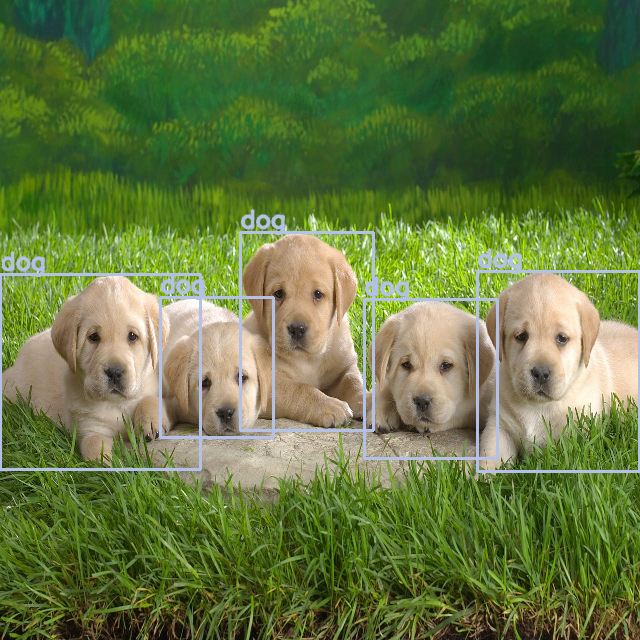

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import os    
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img


def renormalize_cam_in_bounding_boxes(boxes, colors, names, image_float_np, grayscale_cam, output, image_name='test', model='v5X'):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    crops = []
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    for x1, y1, x2, y2 in boxes:
        renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    

    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=False)
    for i, ((x1, y1, x2, y2), name) in enumerate(zip(boxes, names)):
        cropped_image = eigencam_image_renormalized[y1:y2, x1:x2]
        output_path = os.path.join(output, f"{image_name}_crop_{model}_{name}_{i}.png")
        cv2.imwrite(output_path, cropped_image)
        crops.append(cropped_image)
                                                 
    image_with_bounding_boxes = draw_detections(boxes, colors, names, eigencam_image_renormalized)
    return image_with_bounding_boxes, crops

In [ ]:
%cd '/content/drive/MyDrive/Palmer-detection/eigen-cam'
YOLO_V5_PATH = '/content/drive/MyDrive/Palmer-detection/yolov5' # path to the repository if using a local model file
MODEL_FILE = '/content/drive/MyDrive/Palmer-detection/eigen-cam/yolov5s_pags8.pt' # path to the trained model
IMAGE_FILE = 'test1.jpg'

In [ ]:
# model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True) # this will load a pretrained model
model = torch.hub.load('ultralytics/yolov5', 'custom', path=MODEL_FILE, force_reload=True) # this will load a custom model
model.eval()
model.cpu()

Load the image.

In [ ]:
image = cv2.imread(IMAGE_FILE)
image = cv2.resize(image, (1280, 1280))
rgb_img = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB) 
image = np.float32(image) / 255
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)

Run the model on the image and display the detections.

![image](https://github.com/geezacoleman/Palmer-detection/assets/51358498/e76167a3-f9ef-4d4b-8cc4-c5ffbeca7e76)

In [ ]:
results = model([rgb_img.copy()])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, rgb_img.copy())
Image.fromarray(detections)

Now let's create our CAM model and run it on the image. We have selected the last layer in the model detection head. Feel free to play around with this value.

In [ ]:
target_layers = [model.model.model.model[-1].m[-1]]

In [ ]:
cam = EigenCAM(model, target_layers, use_cuda=True)
grayscale_cam = cam(tensor)[0, :, :]
cam_image = show_cam_on_image(image, grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

![image](https://github.com/geezacoleman/Palmer-detection/assets/51358498/5d051d35-5102-41a0-af8d-788e13c57b3c)

This heatmap highlights the Palmer amaranth in the centre of the image, clearly focusing on the central inflorescence. We can further refine this by focusing the heatmap on the detected area only.

In [ ]:
SAVE_DIRECTORY = '/content/drive/MyDrive/Colab Notebooks/palmer_amaranth/eigen-cam/bbox_crops'

renormalized_cam_image, crops = renormalize_cam_in_bounding_boxes(boxes, colors, names, image, grayscale_cam, SAVE_DIRECTORY)
Image.fromarray(crops[0])

We can also iterate over an entire directory of images and save the renormalised bounding box heatmaps to a directory. This is the process we used in the paper.

In [ ]:
from tqdm import tqdm

INPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/palmer_amaranth/eigen-cam/images'

for image_file in tqdm(os.listdir(INPUT_DIR)):
  image_path = os.path.join(INPUT_DIR, image_file)

  image = cv2.imread(image_path)
  image = cv2.resize(image, (1280, 1280))
  rgb_img = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB) 
  image = np.float32(image) / 255
  transform = transforms.ToTensor()
  tensor = transform(image).unsqueeze(0)

  results = model([rgb_img.copy()])
  boxes, colors, names = parse_detections(results)

  cam = EigenCAM(model, target_layers, use_cuda=True)
  grayscale_cam = cam(tensor)[0, :, :]

  renormalized_cam_image, crops = renormalize_cam_in_bounding_boxes(boxes, colors, names, image, grayscale_cam, SAVE_DIRECTORY, os.path.basename(image_path), model='v5x')